## Libraries

In [49]:
import numpy as np
import pandas as pd

# We import the sk learn modules we'll need to segment our new data. We'll need scaler, pca and k-means.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# We import pickle in order to be able to load our pickled objects.
import pickle
# We import the Logistic Regression module from sk learn for the purchase probability model.
from sklearn.linear_model import LogisticRegression 
#We import the necessary libraries for visualization. We set seaborn do be our default.
import matplotlib.pyplot as plt
import matplotlib.axes as axs
import seaborn as sns
sns.set()
# We import the Linear Regression module from sk learn for the quantity model.
from sklearn.linear_model import LinearRegression

## Data Preparation

In [50]:
#load data
df_purchase = pd.read_csv('data/purchase data.csv')
# Import Scaler
scaler = pickle.load(open('scaler.pickle', 'rb'))
# Import PCA
pca = pickle.load(open('pca.pickle', 'rb'))
# Import K-Means
kmeans_pca = pickle.load(open('kmeans_pca.pickle', 'rb'))

# Standardization
features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income', 'Occupation', 'Settlement size']]
df_purchase_segm_std = scaler.transform(features)

# Apply PCA
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

# Segment data
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

# Create a copy of the data frame
df_purchase_predictors = df_purchase.copy()

# Add segment labels
df_purchase_predictors['Segment'] = purchase_segm_kmeans_pca
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, prefix = 'Segment', prefix_sep = '_')
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

df_pa = df_purchase_predictors

In [51]:
df_pa.columns

Index(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4',
       'Promotion_5', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size', 'Segment', 'Segment_0', 'Segment_1',
       'Segment_2', 'Segment_3'],
      dtype='object')

In [52]:
df_pa['Segment_1']

0        1
1        1
2        1
3        1
4        1
        ..
58688    1
58689    1
58690    1
58691    1
58692    1
Name: Segment_1, Length: 58693, dtype: uint8

## Purchase Probability Model

In [53]:
# In order to predict we need input and output variables. 
# Our Y is Incidence, as we want to predict the purchase probability for our customers
Y = df_pa['Incidence']

In [54]:
Y

0        0
1        0
2        0
3        0
4        0
        ..
58688    0
58689    0
58690    0
58691    1
58692    0
Name: Incidence, Length: 58693, dtype: int64

In [55]:
# Our dependant variable is based on the average price of chocolate candy bars. 
# Therefore, X is a data frame, containing the mean across the five prices.
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] +
                   df_pa['Price_2'] +
                   df_pa['Price_3'] +
                   df_pa['Price_4'] +
                   df_pa['Price_5'] ) / 5

In [56]:
# We create a Logistic Regression model using sk learn. Then we fit the model with our X or price and our Y or incidence.
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
# The coefficients for price. It is negative, signaling that with an increase in price, the purchase probability decreases.
model_purchase.coef_

array([[-2.34776111]])

## Price Elasticity of Purchase Probability

In [58]:
# Here we see the prices for the five different brands, which is an important factor in determining purchase probability. 
# It informs the price range, for which we will be exploring purchase probability.
df_pa[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [59]:
# We introduce the price range for which we'll examine the purchase probability.
# We choose a price range between 0.5 and 3.49, which somewhat expands the actual observed price range, 
# which is from 1.1 to 2.8. 
price_range = np.arange(0.5, 3.5, 0.01)
price_range

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
       0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82,
       0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93,
       0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04,
       1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37,
       1.38, 1.39, 1.4 , 1.41, 1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48,
       1.49, 1.5 , 1.51, 1.52, 1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59,
       1.6 , 1.61, 1.62, 1.63, 1.64, 1.65, 1.66, 1.67, 1.68, 1.69, 1.7 ,
       1.71, 1.72, 1.73, 1.74, 1.75, 1.76, 1.77, 1.78, 1.79, 1.8 , 1.81,
       1.82, 1.83, 1.84, 1.85, 1.86, 1.87, 1.88, 1.89, 1.9 , 1.91, 1.92,
       1.93, 1.94, 1.95, 1.96, 1.97, 1.98, 1.99, 2.

In [60]:
df_price_range = pd.DataFrame(price_range)

In [61]:
# We predict the purchase probability for our newly defined price range. 
# The result is a 2x300  array. The first column shows the probability for not purchasing the product, 
# the second the probability for purchase for each price point in our price range.
Y_pr = model_purchase.predict_proba(df_price_range)
purchase_pr = Y_pr[:][:, 1]
# purchase_pr = Y_pr[:, 1]

pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

In [62]:
#Test
#Y_pr
#Y_pr[1]
#print(Y_pr[:, 1])
model_purchase.coef_[:, 0]

array([-2.34776111])

In [63]:
# Create price elasticities master data frame.
# It will contain all the elasticities we calculate during the purchase analytics part of the course.
df_price_elasticities = pd.DataFrame(price_range)

In [64]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: "Price_Point"})
df_price_elasticities['Mean_PE'] = pe
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096410
1,0.51,-0.100479
2,0.52,-0.104674
3,0.53,-0.108999
4,0.54,-0.113458
...,...,...
295,3.45,-8.011846
296,3.46,-8.037093
297,3.47,-8.062306
298,3.48,-8.087485


In [65]:
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096410
1,0.51,-0.100479
2,0.52,-0.104674
3,0.53,-0.108999
4,0.54,-0.113458
5,0.55,-0.118053
6,0.56,-0.122788
7,0.57,-0.127667
8,0.58,-0.132692
9,0.59,-0.137867


Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

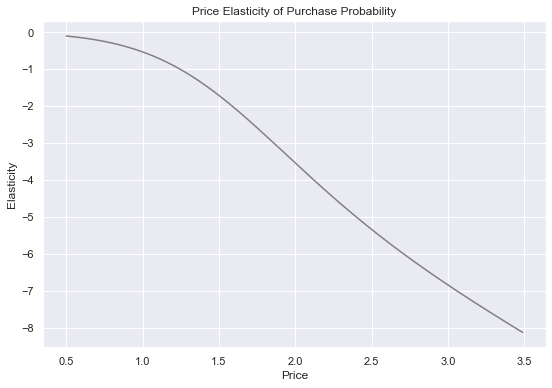

In [66]:
# We display the price elasticity of purchase probability of the average customer.
# We observe that the price elasticities are all negative. Furthermore we can spot where the customer becomes inelastic.
# But to find the precise spot we can consult the price elasticities data frame.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability by Segments

### $\color{green}{\text{Segment 3 - Career-Focused}}$

In [93]:
# We filter the data to contain only customers from segment 1, the career-focused.
df_pa_segment_3 = df_pa[df_pa['Segment'] == 3]

In [94]:
# Again we want to predict the purchase probability, so our Y variable is the incidence column.
# Only here we select only the customers from the first segment.
Y = df_pa_segment_3['Incidence']

In [95]:
X = pd.DataFrame()

In [96]:
# We calculate the average price for purchases in segment 1. Our dependant variable contains the mean price of the brands.
X['Mean_Price'] = (df_pa_segment_3['Price_1'] + 
                   df_pa_segment_3['Price_2'] + 
                   df_pa_segment_3['Price_3'] + 
                   df_pa_segment_3['Price_4'] + 
                   df_pa_segment_3['Price_5']) / 5

In [102]:
# Fit logistic regression model
model_incidence_segment_3 = LogisticRegression(solver = 'sag')
model_incidence_segment_3.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [103]:
# We observe that the price coefficient for the career focused is -1.7, whereas for the average customer it was -2.35.
# This is an indicator, that this segment is less price sensitive compared to the average customer.
model_incidence_segment_3.coef_

array([[-1.71218446]])

In [105]:
# Calculate Price Elasticity of the career-focused segment.
Y_segment_3 = model_incidence_segment_3.predict_proba(df_price_range)
purchase_pr_segment_3 = Y_segment_3[:][:, 1]
pe_segment_3 = model_incidence_segment_3.coef_[:, 0] * price_range * (1 - purchase_pr_segment_3)

### Results

In [106]:
df_price_elasticities['PE_Segment_3'] = pe_segment_3

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

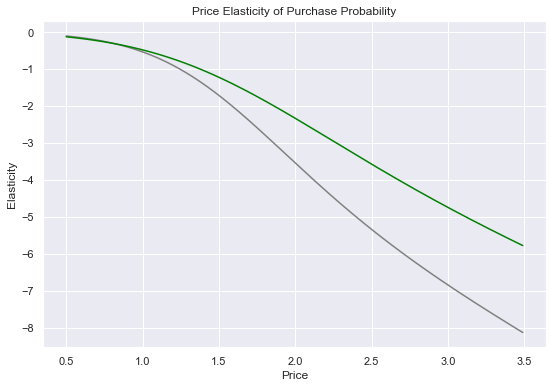

In [107]:
# We plot the elasticities of the average customer and the career-focused segment side by side. 
# The career-focused segment is displayed in green. The same color we used during the descriptive analysis.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_3, color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

### $\color{red}{\text{Segment 1 - Fewer-Opportunities}}$

In [113]:
# Select only customers from segment 1, the fewer-opportunities.
df_pa_segment_1 = df_pa[df_pa['Segment'] == 1]

In [109]:
# Logistic regression model
Y = df_pa_segment_1['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_1['Price_1'] + 
                   df_pa_segment_1['Price_2'] + 
                   df_pa_segment_1['Price_3'] + 
                   df_pa_segment_1['Price_4'] + 
                   df_pa_segment_1['Price_5']) / 5

model_incidence_segment1 = LogisticRegression(solver = 'sag')
model_incidence_segment1.fit(X, Y)

# Calculate price elasticities
model_incidence_segment1.coef_
Y_segment_1 = model_incidence_segment1.predict_proba(df_price_range)
purchase_pr_segment1 = Y_segment_1[:][: , 1]
pe_segment1 = model_incidence_segment1.coef_[:,0] * price_range * ( 1- purchase_pr_segment1)

### Results

In [110]:
df_price_elasticities['PE_Segment_1'] = pe_segment1

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

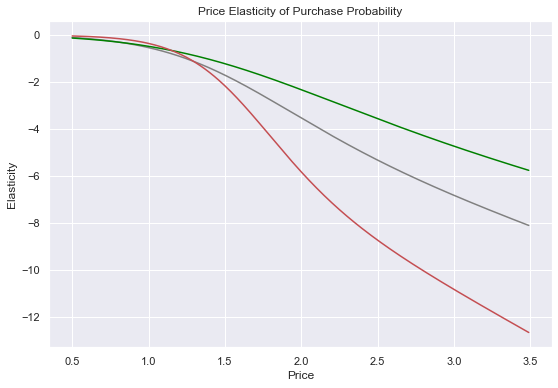

In [111]:
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_3, color = 'green')
plt.plot(price_range, pe_segment1, color = 'r')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## ${\textbf{Homework}}$

### $\color{blue}{\text{Segment 0 - Standard}}$

In [114]:
# Select only customers from segment 0, the standard segment.
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
# Prepare dependant and independant variables.
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment0.predict_proba(df_price_range)
purchase_pr_segment0 = Y_segment_0[:][: , 1]
pe_segment0 = model_incidence_segment0.coef_[:,0] * price_range *( 1- purchase_pr_segment0)
df_price_elasticities.insert(2, column = 'PE_Segment_0', value = pe_segment0)

ValueError: cannot insert PE_Segment_0, already exists

### $\color{orange}{\text{Segment 3 - Well-Off}}$

In [91]:
# Select only customers from segment 3 
df_pa_segment_0 = df_pa[df_pa['Segment'] == 0]
# Prepare dependant and independant variables.
Y = df_pa_segment_0['Incidence']

X = pd.DataFrame()
# Calculate average price for this segment
X['Mean_Price'] = (df_pa_segment_0['Price_1'] + 
                   df_pa_segment_0['Price_2'] + 
                   df_pa_segment_0['Price_3'] + 
                   df_pa_segment_0['Price_4'] + 
                   df_pa_segment_0['Price_5']) / 5
# Logistic regression model
model_incidence_segment0 = LogisticRegression(solver = 'sag')
model_incidence_segment0.fit(X, Y)

model_incidence_segment0.coef_
Y_segment_0 = model_incidence_segment2.predict_proba(df_price_range)
purchase_pr_segment3 = Y_segment_3[:][: , 1]
pe_segment3 = model_incidence_segment3.coef_[:,0] * price_range *( 1- purchase_pr_segment3)
df_price_elasticities['PE_Segment_3'] = pe_segment3
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096410,-0.210026,-0.119194,-0.031016,-0.010630
1,0.51,-0.100479,-0.216601,-0.123381,-0.032787,-0.011236
2,0.52,-0.104674,-0.223286,-0.127662,-0.034645,-0.011873
3,0.53,-0.108999,-0.230081,-0.132037,-0.036594,-0.012541
4,0.54,-0.113458,-0.236987,-0.136509,-0.038638,-0.013242
5,0.55,-0.118053,-0.244005,-0.141079,-0.040781,-0.013976
6,0.56,-0.122788,-0.251136,-0.145748,-0.043028,-0.014746
7,0.57,-0.127667,-0.258381,-0.150518,-0.045382,-0.015553
8,0.58,-0.132692,-0.265739,-0.155391,-0.047849,-0.016398
9,0.59,-0.137867,-0.273213,-0.160367,-0.050434,-0.017284


### ${\textbf{Results}}$

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability')

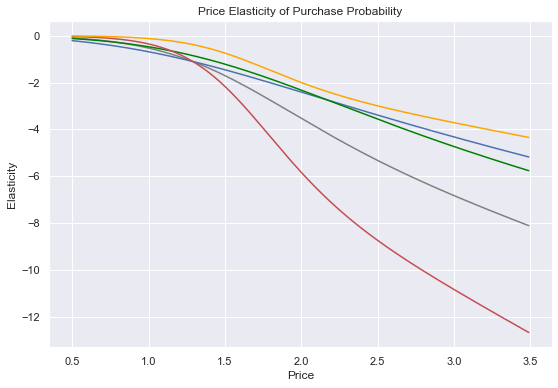

In [92]:
# We display all elasticities of purchase probability on the same plot. 
# We observe that the Career-focused segment are the least elastic when compared to the rest. 
# So, their purchase probability elasticity is not as affected by price.
# The price elasticities for the Standard segment seem to differ across price range. This may be due to the fact that
# the standard segment is least homogenous, which we discovered during our descriptive analysis. 
# It may be that the customers in this segment have different shopping habbits, which is why their 
# customers start with being more elastic than average but then shift to being more inelastic than the average customer
# and indeed the Career-focused segment.
plt.figure(figsize = (9, 6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment0, color = 'b')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment2, color = 'r')
plt.plot(price_range, pe_segment3, color = 'orange')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability')

## Purchase Probability with Promotion Feature

### Data Preparation

In [32]:
Y = df_pa['Incidence']

In [33]:
X = pd.DataFrame()
X['Mean_Price'] = (df_pa['Price_1'] + 
                   df_pa['Price_2'] + 
                   df_pa['Price_3'] + 
                   df_pa['Price_4'] + 
                   df_pa['Price_5']) / 5

In [34]:
# We include a second promotion feature. We'd like to examine the effects of promotions on purchase probability.
# We calculate the average promotion rate across the five brands. We add the mean price for the brands.
X['Mean_Promotion'] = (df_pa['Promotion_1'] +
                       df_pa['Promotion_2'] +
                       df_pa['Promotion_3'] +
                       df_pa['Promotion_4'] +
                       df_pa['Promotion_5'] ) / 5
X.head()

,Mean_Price,Mean_Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0


## Model Estimation

In [35]:
# The coefficient for promotion is positive. 
# Therefore, there is a positive relationship between promotion and purchase probability.
model_incidence_promotion = LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49389966,  0.56123346]])

## Price Elasticity with Promotion

In [36]:
# We create a data frame on which our model will predict. We need to include A price and promotion feature.
# First, we'll include the price range as the price feature. Next, we'll include the promotion feature.
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0: "Price_Range"})

In [37]:
# We'll calculate price elasticities of purchase probability when we assume there is a promotion across at each price points.
df_price_elasticity_promotion['Promotion'] = 1

In [38]:
# Purchase Probability with Promotion Model Prediction
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion)

In [39]:
promo = Y_promotion[:, 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo)

In [40]:
# Update master data to include elasticities of purchase probability with promotion feature
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_0,PE_Segment_1,PE_Segment_2,PE_Segment_3,Elasticity_Promotion_1
0,0.50,-0.096465,-0.167969,-0.030990,-0.210017,-0.236285,-0.125782
1,0.51,-0.100537,-0.172891,-0.032760,-0.216591,-0.243682,-0.129899
2,0.52,-0.104735,-0.177883,-0.034618,-0.223275,-0.251202,-0.134096
3,0.53,-0.109064,-0.182947,-0.036566,-0.230069,-0.258846,-0.138372
4,0.54,-0.113526,-0.188081,-0.038609,-0.236975,-0.266615,-0.142729
5,0.55,-0.118125,-0.193287,-0.040751,-0.243992,-0.274510,-0.147169
6,0.56,-0.122863,-0.198566,-0.042997,-0.251122,-0.282532,-0.151691
7,0.57,-0.127746,-0.203917,-0.045351,-0.258366,-0.290681,-0.156297
8,0.58,-0.132775,-0.209341,-0.047817,-0.265723,-0.298959,-0.160988
9,0.59,-0.137954,-0.214839,-0.050402,-0.273196,-0.307366,-0.165765


## Price Elasticity without Promotion

In [41]:
df_price_elasticity_promotion_no = pd.DataFrame(price_range)
df_price_elasticity_promotion_no = df_price_elasticity_promotion_no.rename(columns = {0: "Price_Range"})

In [42]:
# Promotion feature -No Promotion.
# We assume there aren't any promotional activities on any of the price points.
# We examine the elasticity of purchase probability when there isn't promotion.
df_price_elasticity_promotion_no['Promotion'] = 0

In [43]:
#Purchase Probability without Promotion Model Prediction
Y_no_promo = model_incidence_promotion.predict_proba(df_price_elasticity_promotion_no)

In [44]:
no_promo = Y_no_promo[: , 1]

In [45]:
price_elasticity_no_promo = model_incidence_promotion.coef_[:, 0] * price_range *(1- no_promo)

In [46]:
# Update master data frame to include purchase probability elasticities without promotion.
# We can now see the values with and without promotion and compare them for each price point in our price range.
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_no_promo

Text(0.5, 1.0, 'Price Elasticity of Purchase Probability with and without Promotion')

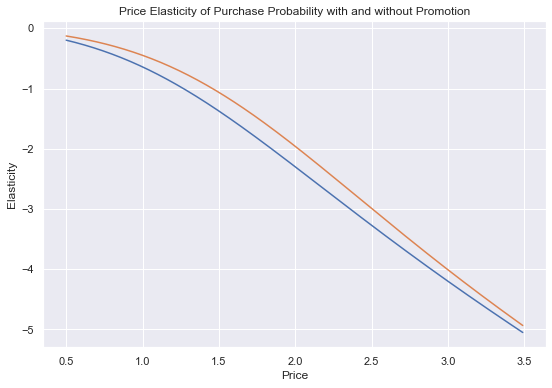

In [47]:
# Plot purchase elasticities with and without promotion side by side for comprarisson.
# Here we observe that the purchase probability elasticity of the customer is less elastic when there is promotion.
# This is an important insight for marketers, as according to our model people are more likely to buy a product if there is
# some promotional activity rather than purchase a product with the same price, when it isn't on promotion. 
plt.figure(figsize = (9, 6))
plt.plot(price_range, price_elasticity_no_promo)
plt.plot(price_range, price_elasticity_promo)
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of Purchase Probability with and without Promotion')